<a href="https://colab.research.google.com/github/Maxibrionest/MachineLearning/blob/main/Entrega2/Entrega2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning, caso de estudio Monopoly/Dormammu**

Nombre: Maximiliano Briones / Lucas Vásquez

Sección: 003V

Evaluación: 2

Fecha de entrega: 19/11/2021

---


## **Fase I. Business Understanding**

El banco "Monopoly" fue adquirido recientemente por el banco, con capitales extranjeros, "Dormammu". Éste encargó hacer estudios sobre la adquisición, determinando  comportamiento, patrones y una estrategia para abordar a los nuevos clientes.

La base de datos que se extrajo corresponde a una muestra de 12 meses con información de clientes, en variables mensuales para cada uno.

[Link a enunciado original](https://github.com/Maxibrionest/MachineLearning/blob/main/Entrega1/ET221_3A_MLY0100.docx).

En base a lo anterior, se determinó como target el monto de pagos de deuda internacional del cliente en el mes 12.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
sheetname = 'Transición de Negocio'
path_to_file = '/gdrive/MyDrive/DUOC/2021 - 2/MLY/Entrega2/Base_clientes_Monopoly.xlsx'
df = pd.read_excel(path_to_file, sheet_name=sheetname, header=1)

# Sección nueva

Al ver el excel, existe una suma que da cuenta de la cantidad de columnas y que está en la misma altura que los headers de las columnas, por lo que se eliminará al no aportar valor.

In [79]:
df.columns

Index(['Id', 'Subsegmento', 'Sexo', 'Region', 'Edad', 'Renta', 'Antiguedad',
       'Internauta', 'Adicional', 'Dualidad',
       ...
       'ColMx_T01', 'PagoNac_T01', 'PagoInt_T01', 'EeccNac_T01', 'EeccInt_T01',
       'UsoL1_T01', 'UsoL2_T01', 'UsoLI_T01', 'IndRev_T01', 'target'],
      dtype='object', length=574)

In [6]:
df = df.drop(columns=['Unnamed: 574'])

In [7]:
print("Cantidad de observaciones: ", df.shape[0])
print("Cantidad de columnas:      ", df.shape[1])
print("Cantidad de datos:         ", df.shape[0] * df.shape[1])
observaciones = df.shape[0]

Cantidad de observaciones:  51124
Cantidad de columnas:       574
Cantidad de datos:          29345176


In [8]:
corrdat = df.corr()

In [9]:
def getCorr(dat, lim): #obtiene los features con mayor impacto en el target
    feature = []
    valor = []
    
    for i , index in enumerate(dat.index): #bucle para todos los indices
        if abs(dat[index]) > lim:
            feature.append(index)
            print(index)
            valor.append(dat[index])

    df = pd.DataFrame(data = valor, index = feature, columns = ['corr value'])

    return df

In [112]:
lim = 0.01
corr_value = getCorr(corrdat['PagoInt_T12'], lim)

Hipotecario
CUPO_L1
CUPO_MX
FacCI_T12
PagoInt_T12
FlgActCCOT_T11
PagoInt_T07


In [11]:
corrdat['PagoInt_T12'].sort_values(key=abs, ascending=False)

PagoInt_T12       1.000000
CUPO_L1           0.017535
FlgActCCOT_T11    0.013894
FacCI_T12         0.012834
Hipotecario       0.011549
                    ...   
ColL1T0_T03      -0.000029
ColL2CC_T07      -0.000024
TxsDebAtm_T02     0.000018
TxsDebAtm_T07     0.000009
CambioPin              NaN
Name: PagoInt_T12, Length: 561, dtype: float64

#### Region
Región de residencia del cliente. Rango de valores de 1 a 13 inclusivos, por lo que se asume que no está aplicada la división de 2018, tomando en cuenta 13 regiones con la metropolitana como número 13.

In [12]:
print("Cantidad de MV en variable: ", df['Region'].isnull().sum())
print(f"Porcentaje de MV: {round(df['Region'].isnull().sum()/observaciones*100,3)}%")

Cantidad de MV en variable:  53
Porcentaje de MV: 0.104%


Buscamos un sistema que modele segun los datos del mes anterior (POR AHORA)

In [13]:
df.columns

Index(['Id', 'Subsegmento', 'Sexo', 'Region', 'Edad', 'Renta', 'Antiguedad',
       'Internauta', 'Adicional', 'Dualidad',
       ...
       'ColMx_T01', 'PagoNac_T01', 'PagoInt_T01', 'EeccNac_T01', 'EeccInt_T01',
       'UsoL1_T01', 'UsoL2_T01', 'UsoLI_T01', 'IndRev_T01', 'target'],
      dtype='object', length=574)

In [14]:
lim = 0.55
corr_value = getCorr(corrdat['target'], lim)

target


In [15]:
corrdat['PagoInt_T12'].sort_values(key=abs, ascending=False)

PagoInt_T12       1.000000
CUPO_L1           0.017535
FlgActCCOT_T11    0.013894
FacCI_T12         0.012834
Hipotecario       0.011549
                    ...   
ColL1T0_T03      -0.000029
ColL2CC_T07      -0.000024
TxsDebAtm_T02     0.000018
TxsDebAtm_T07     0.000009
CambioPin              NaN
Name: PagoInt_T12, Length: 561, dtype: float64

In [17]:
cols_flag = []
for i in df.columns:
  if i[0:3] == "Flg":
    cols_flag.append(i)


In [19]:
print(cols_flag)
print(len(cols_flag))

['FlgAct_T12', 'FlgActCN_T12', 'FlgActCI_T12', 'FlgActAN_T12', 'FlgActAI_T12', 'FlgActPAT_T12', 'FlgActCCPC_T12', 'FlgActCCOT_T12', 'FlgActCOL_T12', 'FlgAct_T11', 'FlgActCN_T11', 'FlgActCI_T11', 'FlgActAN_T11', 'FlgActAI_T11', 'FlgActPAT_T11', 'FlgActCCPC_T11', 'FlgActCCOT_T11', 'FlgActCOL_T11', 'FlgAct_T10', 'FlgActCN_T10', 'FlgActCI_T10', 'FlgActAN_T10', 'FlgActAI_T10', 'FlgActPAT_T10', 'FlgActCCPC_T10', 'FlgActCCOT_T10', 'FlgActCOL_T10', 'FlgAct_T09', 'FlgActCN_T09', 'FlgActCI_T09', 'FlgActAN_T09', 'FlgActAI_T09', 'FlgActPAT_T09', 'FlgActCCPC_T09', 'FlgActCCOT_T09', 'FlgActCOL_T09', 'FlgAct_T08', 'FlgActCN_T08', 'FlgActCI_T08', 'FlgActAN_T08', 'FlgActAI_T08', 'FlgActPAT_T08', 'FlgActCCPC_T08', 'FlgActCCOT_T08', 'FlgActCOL_T08', 'FlgAct_T07', 'FlgActCN_T07', 'FlgActCI_T07', 'FlgActAN_T07', 'FlgActAI_T07', 'FlgActPAT_T07', 'FlgActCCPC_T07', 'FlgActCCOT_T07', 'FlgActCOL_T07', 'FlgAct_T06', 'FlgActCN_T06', 'FlgActCI_T06', 'FlgActAN_T06', 'FlgActAI_T06', 'FlgActPAT_T06', 'FlgActCCPC_T06'

In [20]:
def buscar_cols(texto, numero):
  columnas = []
  for i in df.columns:
    columnas.append(i)
  col = []
  for i in columnas:
    if i[0:numero] == texto:
      col.append(i)
  return col

In [21]:
col_Txs_T = buscar_cols("Txs_T", 5)
print(col_Txs_T)

['Txs_T12', 'Txs_T11', 'Txs_T10', 'Txs_T09', 'Txs_T08', 'Txs_T07', 'Txs_T06', 'Txs_T05', 'Txs_T04', 'Txs_T03', 'Txs_T02', 'Txs_T01']


In [27]:
def buscar_t12():
    cols_a_dropear = []
    for i in df.columns:
        if i[-3:] == "T12":
            cols_a_dropear.append(i)
    return cols_a_dropear

In [29]:
cols_drop_1 = buscar_t12()
cols_drop_1

['FlgAct_T12',
 'FlgActCN_T12',
 'FlgActCI_T12',
 'FlgActAN_T12',
 'FlgActAI_T12',
 'FlgActPAT_T12',
 'FlgActCCPC_T12',
 'FlgActCCOT_T12',
 'FlgActCOL_T12',
 'Fac_T12',
 'Txs_T12',
 'FacCN_T12',
 'TxsCN_T12',
 'FacCI_T12',
 'TxsCI_T12',
 'FacAN_T12',
 'TxsAN_T12',
 'FacAI_T12',
 'TxsAI_T12',
 'FacPAT_T12',
 'TxsPAT_T12',
 'FacCCPC_T12',
 'TxsCCPC_T12',
 'FacCCOT_T12',
 'TxsCCOT_T12',
 'FacCOL_T12',
 'TxsCOL_T12',
 'FacDebCom_T12',
 'TxsDebCom_T12',
 'FacDebAtm_T12',
 'TxsDebAtm_T12',
 'Col_T12',
 'ColL1T0_T12',
 'ColL1TE_T12',
 'ColL2T0_T12',
 'ColL2AC_T12',
 'ColL2CC_T12',
 'ColMx_T12',
 'PagoNac_T12',
 'PagoInt_T12',
 'EeccNac_T12',
 'EeccInt_T12',
 'UsoL1_T12',
 'UsoL2_T12',
 'UsoLI_T12',
 'IndRev_T12']

In [30]:
df_1 = df.drop(columns=cols_drop_1)

In [33]:
df_1.drop(columns=["target"])

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAN_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,FlgActCOL_T11,Fac_T11,Txs_T11,FacCN_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAN_T11,TxsAN_T11,FacAI_T11,TxsAI_T11,...,FlgActCCPC_T01,FlgActCCOT_T01,FlgActCOL_T01,Fac_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,FacAN_T01,TxsAN_T01,FacAI_T01,TxsAI_T01,FacPAT_T01,TxsPAT_T01,FacCCPC_T01,TxsCCPC_T01,FacCCOT_T01,TxsCCOT_T01,FacCOL_T01,TxsCOL_T01,FacDebCom_T01,TxsDebCom_T01,FacDebAtm_T01,TxsDebAtm_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2AC_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01
0,1,160,M,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204133,28,24000,2,1069735.0,0,1040339.0,0,0,29396,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R
1,2,160,H,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,291725.0,8.0,291725.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,118247,1,118247,1,0,0,0,0,0,0,0,0,118247,1,0,0,0,0,0,0,0,0,211884.0,0,162939.0,48945,0,0,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R
2,3,170,H,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,191336,3,191336,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,162161,9,519000,11,7400.0,7400,0.0,0,0,0,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T
3,4,151,H,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,72416.0,4.0,72416.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,11890,1,11890,1,0,0,0,0,0,0,0,0,11890,1,0,0,0,0,0,0,0,0,262160.0,0,244048.0,18112,0,0,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R
4,5,170,H,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,526687.0,12.0,526687.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,173576,10,173576,10,0,0,0,0,0,0,0,0,70808,3,47000,1,0,0,0,0,0,0,306161.0,60008,0.0,214125,0,32028,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,71470.0,8.0,71470.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,62808,5,62808,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1112000,14,463255.0,62808,379646.0,20801,0,0,0.0,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R
51120,51121,170,H,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,56666.0,2.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,37783,1,0,0,0,0,0,0,0,0,37783,1,0,0,0,0,0,0,0,0,0,0,728406.0,37783,0.0,91896,0,598727,0.0,166098,0.0,166098.0,0.0,0.0,572363,0.0,R
51121,51122,160,H,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24373.0,0,24.0,0,0,24349,0.0,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R
51122,51123,160,M,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,108982,2,108982,2,0,0,0,0,0,0,0,0,84982,1,0,0,0,0,0,0,0,0,52360.0,24000,33.0,28327,0,0,0.0,26528,0.0,24638.0,0.0,24638.0,84982,0.0,R


In [37]:
target = df["PagoInt_T12"]

In [38]:
df_1["target"] = target

In [80]:
df_1

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAN_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,FlgActCOL_T11,Fac_T11,Txs_T11,FacCN_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAN_T11,TxsAN_T11,FacAI_T11,TxsAI_T11,...,FlgActCCOT_T01,FlgActCOL_T01,Fac_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,FacAN_T01,TxsAN_T01,FacAI_T01,TxsAI_T01,FacPAT_T01,TxsPAT_T01,FacCCPC_T01,TxsCCPC_T01,FacCCOT_T01,TxsCCOT_T01,FacCOL_T01,TxsCOL_T01,FacDebCom_T01,TxsDebCom_T01,FacDebAtm_T01,TxsDebAtm_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2AC_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204133,28,24000,2,1069735.0,0,1040339.0,0,0,29396,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0.0
1,2,160,H,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,291725.0,8.0,291725.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,118247,1,118247,1,0,0,0,0,0,0,0,0,118247,1,0,0,0,0,0,0,0,0,211884.0,0,162939.0,48945,0,0,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0.0
2,3,170,H,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,191336,3,191336,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,162161,9,519000,11,7400.0,7400,0.0,0,0,0,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0.0
3,4,151,H,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,72416.0,4.0,72416.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,11890,1,11890,1,0,0,0,0,0,0,0,0,11890,1,0,0,0,0,0,0,0,0,262160.0,0,244048.0,18112,0,0,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0.0
4,5,170,H,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,526687.0,12.0,526687.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,173576,10,173576,10,0,0,0,0,0,0,0,0,70808,3,47000,1,0,0,0,0,0,0,306161.0,60008,0.0,214125,0,32028,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,71470.0,8.0,71470.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,62808,5,62808,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1112000,14,463255.0,62808,379646.0,20801,0,0,0.0,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R,0.0
51120,51121,170,H,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,56666.0,2.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,37783,1,0,0,0,0,0,0,0,0,37783,1,0,0,0,0,0,0,0,0,0,0,728406.0,37783,0.0,91896,0,598727,0.0,166098,0.0,166098.0,0.0,0.0,572363,0.0,R,0.0
51121,51122,160,H,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24373.0,0,24.0,0,0,24349,0.0,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R,0.0
51122,51123,160,M,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,108982,2,108982,2,0,0,0,0,0,0,0,0,84982,1,0,0,0,0,0,0,0,0,52360.0,24000,33.0,28327,0,0,0.0,26528,0.0,24638.0,0.0,24638.0,84982,0.0,R,NaN


In [44]:
corrdat_1 = df_1.corr()

In [45]:
lim = 0.01
corr_value_1 = getCorr(corrdat_1['target'], lim)

Hipotecario
CUPO_L1
CUPO_MX
FlgActCCOT_T11
PagoInt_T07
target


In [46]:
corrdat_1['target'].sort_values(key=abs, ascending=False)

target            1.000000
CUPO_L1           0.017535
FlgActCCOT_T11    0.013894
Hipotecario       0.011549
CUPO_MX           0.010990
                    ...   
ColL1T0_T03      -0.000029
ColL2CC_T07      -0.000024
TxsDebAtm_T02     0.000018
TxsDebAtm_T07     0.000009
CambioPin              NaN
Name: target, Length: 516, dtype: float64

In [49]:
corrdat_1['target'].sort_values(key=abs, ascending=False).tail(100)

Ctacte           0.000712
FlgActAN_T09    -0.000711
TxsAN_T07       -0.000708
Fac_T04         -0.000681
ColL1T0_T04     -0.000677
                   ...   
ColL1T0_T03     -0.000029
ColL2CC_T07     -0.000024
TxsDebAtm_T02    0.000018
TxsDebAtm_T07    0.000009
CambioPin             NaN
Name: target, Length: 100, dtype: float64

In [64]:
df_cols_drop_100 = pd.DataFrame(data=corrdat_1['target'].sort_values(key=abs, ascending=False).tail(100))
cols_drop_100 = []
for i in df_cols_drop_100.index:
    cols_drop_100.append(i)

In [73]:
cols_drop_100[5:8]

['ColL2CC_T08', 'FacCCOT_T10', 'Monoproducto']

In [81]:
df_2 = df_1.drop(columns=cols_drop_100)

In [99]:
df_2

,Id,Subsegmento,Sexo,Region,Renta,Antiguedad,Internauta,Adicional,Dualidad,Hipotecario,Debito,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAN_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,Txs_T11,FacCN_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,TxsAN_T11,FacAI_T11,TxsAI_T11,FacPAT_T11,TxsPAT_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,FacDebCom_T11,...,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActCI_T01,FlgActAN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Fac_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsAN_T01,FacPAT_T01,TxsPAT_T01,FacCCPC_T01,TxsCCPC_T01,TxsCCOT_T01,TxsDebAtm_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2AC_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,NaN,130,1,1,0,0,1,1,3,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167618.0,...,1072040.00,29396.0,0.0,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1069735.0,0,1040339.0,0,0,29396,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0.0
1,2,160,H,13.0,143640.0,69,1,0,0,1,0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,291725.0,8.0,291725.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237115.0,5.0,9640.0,1.0,0.0,...,462736.00,9529.0,0.0,R,1,1,0,0,0,1,0,118247,1,118247,1,0,0,0,0,0,118247,1,0,0,211884.0,0,162939.0,48945,0,0,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0.0
2,3,170,H,13.0,929106.0,24,1,1,0,1,1,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48258.0,...,32740.00,0.0,0.0,T,1,1,0,0,0,0,0,191336,3,191336,3,0,0,0,0,0,0,0,0,11,7400.0,7400,0.0,0,0,0,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0.0
3,4,151,H,13.0,172447.0,134,0,1,0,0,0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,72416.0,4.0,72416.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53032.0,2.0,0.0,0.0,0.0,...,303400.00,16813.0,0.0,R,1,1,0,0,0,1,0,11890,1,11890,1,0,0,0,0,0,11890,1,0,0,262160.0,0,244048.0,18112,0,0,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0.0
4,5,170,H,13.0,805250.0,116,0,1,1,1,0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,526687.0,12.0,526687.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,424064.0,6.0,0.0,0.0,0.0,...,93302.00,453873.0,0.0,T,1,1,0,0,0,1,1,173576,10,173576,10,0,0,0,0,0,70808,3,1,0,306161.0,60008,0.0,214125,0,32028,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,364978.0,57,1,1,1,0,1,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,71470.0,8.0,71470.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55610.0,5.0,0.0,0.0,0.0,...,679172.00,32468.0,0.0,R,1,1,0,0,0,0,0,62808,5,62808,5,0,0,0,0,0,0,0,0,14,463255.0,62808,379646.0,20801,0,0,0.0,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R,0.0
51120,51121,170,H,13.0,625376.0,39,1,0,0,0,1,1,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,56666.0,2.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,26921.0,1.0,29745.0,1.0,0.0,0.0,0.0,...,0.00,690623.0,0.0,R,1,0,0,0,1,0,0,37783,1,0,0,0,0,0,37783,1,0,0,0,0,728406.0,37783,0.0,91896,0,598727,0.0,166098,0.0,166098.0,0.0,0.0,572363,0.0,R,0.0
51121,51122,160,H,13.0,806220.0,153,1,1,0,0,1,1,2,1061000,194700.0,1526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18891.00,24349.0,0.0,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24373.0,0,24.0,0,0,24349,0.0,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R,0.0
51122,51123,160,M,13.0,NaN,11,1,0,0,0,0,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26528.00,0.0,

In [83]:
corrdat_2 = df_2.corr()

In [84]:
lim = 0.01
corr_value_2 = getCorr(corrdat_2['target'], lim)

Hipotecario
CUPO_L1
CUPO_MX
FlgActCCOT_T11
PagoInt_T07
target


In [85]:
corrdat_2['target'].sort_values(key=abs, ascending=False)

target            1.000000
CUPO_L1           0.017535
FlgActCCOT_T11    0.013894
Hipotecario       0.011549
CUPO_MX           0.010990
                    ...   
PagoNac_T08      -0.000774
FacAI_T05         0.000769
PagoNac_T05      -0.000760
FacCCOT_T09      -0.000743
ColL2CC_T06      -0.000737
Name: target, Length: 416, dtype: float64

In [86]:
corrdat_2['target'].sort_values(key=abs, ascending=False).tail(100)

TxsCCOT_T03   -0.001585
FacCN_T03     -0.001583
TxsPAT_T11    -0.001573
Col_T10       -0.001559
ColMx_T03      0.001544
                 ...   
PagoNac_T08   -0.000774
FacAI_T05      0.000769
PagoNac_T05   -0.000760
FacCCOT_T09   -0.000743
ColL2CC_T06   -0.000737
Name: target, Length: 100, dtype: float64

In [104]:
df_cols_drop_128 = pd.DataFrame(data=corrdat_2['target'].sort_values(key=abs, ascending=False).tail(128))
cols_drop_128 = []
for i in df_cols_drop_128.index:
    cols_drop_128.append(i)

In [105]:
df_cols_drop_128

,target
FacCCPC_T04,-0.001749
FacCCPC_T08,-0.001744
TxsPAT_T03,-0.001743
FacCCPC_T05,-0.001742
UsoL2_T01,-0.001740
...,...
PagoNac_T08,-0.000774
FacAI_T05,0.000769
PagoNac_T05,-0.000760
FacCCOT_T09,-0.000743


In [106]:
df_3 = df_2.drop(columns=cols_drop_128)

In [107]:
df_3

,Id,Subsegmento,Sexo,Region,Renta,Internauta,Adicional,Dualidad,Hipotecario,Cuentas,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAI_T11,TxsAI_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,TxsDebCom_T11,FacDebAtm_T11,TxsDebAtm_T11,ColL1TE_T11,ColL2T0_T11,ColMx_T11,PagoNac_T11,PagoInt_T11,EeccNac_T11,EeccInt_T11,...,FacDebCom_T02,Col_T02,ColL1T0_T02,ColL1TE_T02,ColL2T0_T02,ColL2CC_T02,ColMx_T02,PagoNac_T02,PagoInt_T02,EeccNac_T02,EeccInt_T02,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsPAT_T01,TxsCCPC_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,UsoL1_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,NaN,1,1,0,0,1,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,122000.0,4.0,676433.0,17260.0,0.0,0.0,0.0,739270.0,0.0,...,157797.0,1063131.0,0.0,1019435.0,0.0,43696.0,0.0,33000.0,0.0,1072040.0,0.0,1072040.00,29396.0,0.0,R,0,0,0,0,0,0,0,0,0,0,0,0,1069735.0,0,1040339.0,0,29396,0.0,33000,0.0,1099866.0,1099866.0,0.0,R,0.0
1,2,160,H,13.0,143640.0,1,0,0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,291725.0,8.0,0.0,0.0,0.0,0.0,237115.0,5.0,9640.0,1.0,0.0,0.0,0.0,95003.0,366706.0,0.0,150000.0,0.0,356576.0,0.0,...,0.0,445899.0,0.0,441135.0,4764.0,0.0,0.0,14000.0,0.0,462736.0,0.0,462736.00,9529.0,0.0,R,1,1,0,1,0,1,118247,1,0,0,0,1,211884.0,0,162939.0,48945,0,0.0,300000,0.0,214592.0,214592.0,0.0,R,0.0
2,3,170,H,13.0,929106.0,1,1,0,1,1,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,689000.0,17.0,0.0,0.0,0.0,178179.0,0.0,0.0,0.0,...,155850.0,48279.0,48279.0,0.0,0.0,0.0,0.0,25189.0,0.0,0.0,0.0,32740.00,0.0,0.0,T,1,1,0,0,0,3,191336,3,0,0,0,0,7400.0,7400,0.0,0,0,0.0,216676,0.0,0.0,7400.0,0.0,T,0.0
3,4,151,H,13.0,172447.0,0,1,0,0,1,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,72416.0,4.0,0.0,0.0,0.0,0.0,53032.0,2.0,0.0,0.0,0.0,0.0,0.0,309221.0,13994.0,0.0,50000.0,0.0,347432.0,0.0,...,0.0,301738.0,0.0,275320.0,23169.0,3249.0,0.0,60000.0,0.0,303400.0,0.0,303400.00,16813.0,0.0,R,1,1,0,1,0,1,11890,1,0,0,0,1,262160.0,0,244048.0,18112,0,0.0,60000,0.0,272762.0,272762.0,0.0,R,0.0
4,5,170,H,13.0,805250.0,0,1,1,1,2,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,526687.0,12.0,0.0,0.0,0.0,0.0,424064.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,176786.0,0.0,245513.0,0.0,225748.0,0.0,...,0.0,284810.0,58706.0,0.0,183400.0,42704.0,0.0,143686.0,0.0,184685.0,0.0,93302.00,453873.0,0.0,T,1,1,0,1,1,10,173576,10,0,0,0,3,306161.0,60008,0.0,214125,32028,0.0,272925,0.0,249562.0,75339.0,0.0,R,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,364978.0,1,1,1,0,2,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,71470.0,8.0,0.0,0.0,0.0,0.0,55610.0,5.0,0.0,0.0,0.0,684000.0,8.0,443366.0,35117.0,0.0,75000.0,0.0,529384.0,0.0,...,0.0,655498.0,24728.0,607072.0,23698.0,0.0,0.0,50000.0,0.0,679172.0,0.0,679172.00,32468.0,0.0,R,1,1,0,0,0,5,62808,5,0,0,0,0,463255.0,62808,379646.0,20801,0,0.0,300000,0.0,478320.0,478320.0,0.0,R,0.0
51120,51121,170,H,13.0,625376.0,1,0,0,0,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,56666.0,1.0,0.0,0.0,0.0,0.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9915.0,0.0,37294.0,0.0,37294.0,0.0,...,0.0,716890.0,0.0,0.0,91896.0,624994.0,0.0,173162.0,0.0,173162.0,0.0,0.00,690623.0,0.0,R,1,0,1,0,0,1,0,0,0,0,1,0,728406.0,37783,0.0,91896,598727,0.0,166098,0.0,166098.0,0.0,0.0,R,0.0
51121,51122,160,H,13.0,806220.0,1,1,0,0,1,1061000,194700.0,1526.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [120]:
df_3.drop(columns=["Id"], inplace=True)

In [121]:
df_3

,Subsegmento,Sexo,Region,Renta,Internauta,Adicional,Dualidad,Hipotecario,Cuentas,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T11,FlgActCN_T11,FlgActCI_T11,FlgActAI_T11,FlgActPAT_T11,FlgActCCPC_T11,FlgActCCOT_T11,Fac_T11,TxsCN_T11,FacCI_T11,TxsCI_T11,FacAI_T11,TxsAI_T11,FacCCPC_T11,TxsCCPC_T11,FacCCOT_T11,TxsCCOT_T11,TxsDebCom_T11,FacDebAtm_T11,TxsDebAtm_T11,ColL1TE_T11,ColL2T0_T11,ColMx_T11,PagoNac_T11,PagoInt_T11,EeccNac_T11,EeccInt_T11,UsoL1_T11,...,FacDebCom_T02,Col_T02,ColL1T0_T02,ColL1TE_T02,ColL2T0_T02,ColL2CC_T02,ColMx_T02,PagoNac_T02,PagoInt_T02,EeccNac_T02,EeccInt_T02,UsoL1_T02,UsoL2_T02,UsoLI_T02,IndRev_T02,FlgAct_T01,FlgActCN_T01,FlgActPAT_T01,FlgActCCPC_T01,FlgActCCOT_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,TxsPAT_T01,TxsCCPC_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,UsoL1_T01,UsoLI_T01,IndRev_T01,target
0,160,M,13.0,NaN,1,1,0,0,1,798000,1012000.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,122000.0,4.0,676433.0,17260.0,0.0,0.0,0.0,739270.0,0.0,739270.0,...,157797.0,1063131.0,0.0,1019435.0,0.0,43696.0,0.0,33000.0,0.0,1072040.0,0.0,1072040.00,29396.0,0.0,R,0,0,0,0,0,0,0,0,0,0,0,0,1069735.0,0,1040339.0,0,29396,0.0,33000,0.0,1099866.0,1099866.0,0.0,R,0.0
1,160,H,13.0,143640.0,1,0,0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,291725.0,8.0,0.0,0.0,0.0,0.0,237115.0,5.0,9640.0,1.0,0.0,0.0,0.0,95003.0,366706.0,0.0,150000.0,0.0,356576.0,0.0,356576.0,...,0.0,445899.0,0.0,441135.0,4764.0,0.0,0.0,14000.0,0.0,462736.0,0.0,462736.00,9529.0,0.0,R,1,1,0,1,0,1,118247,1,0,0,0,1,211884.0,0,162939.0,48945,0,0.0,300000,0.0,214592.0,214592.0,0.0,R,0.0
2,170,H,13.0,929106.0,1,1,0,1,1,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,97474.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,689000.0,17.0,0.0,0.0,0.0,178179.0,0.0,0.0,0.0,14850.0,...,155850.0,48279.0,48279.0,0.0,0.0,0.0,0.0,25189.0,0.0,0.0,0.0,32740.00,0.0,0.0,T,1,1,0,0,0,3,191336,3,0,0,0,0,7400.0,7400,0.0,0,0,0.0,216676,0.0,0.0,7400.0,0.0,T,0.0
3,151,H,13.0,172447.0,0,1,0,0,1,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,72416.0,4.0,0.0,0.0,0.0,0.0,53032.0,2.0,0.0,0.0,0.0,0.0,0.0,309221.0,13994.0,0.0,50000.0,0.0,347432.0,0.0,347432.0,...,0.0,301738.0,0.0,275320.0,23169.0,3249.0,0.0,60000.0,0.0,303400.0,0.0,303400.00,16813.0,0.0,R,1,1,0,1,0,1,11890,1,0,0,0,1,262160.0,0,244048.0,18112,0,0.0,60000,0.0,272762.0,272762.0,0.0,R,0.0
4,170,H,13.0,805250.0,0,1,1,1,2,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,526687.0,12.0,0.0,0.0,0.0,0.0,424064.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,176786.0,0.0,245513.0,0.0,225748.0,0.0,101864.0,...,0.0,284810.0,58706.0,0.0,183400.0,42704.0,0.0,143686.0,0.0,184685.0,0.0,93302.00,453873.0,0.0,T,1,1,0,1,1,10,173576,10,0,0,0,3,306161.0,60008,0.0,214125,32028,0.0,272925,0.0,249562.0,75339.0,0.0,R,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,160,H,13.0,364978.0,1,1,1,0,2,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,71470.0,8.0,0.0,0.0,0.0,0.0,55610.0,5.0,0.0,0.0,0.0,684000.0,8.0,443366.0,35117.0,0.0,75000.0,0.0,529384.0,0.0,543642.0,...,0.0,655498.0,24728.0,607072.0,23698.0,0.0,0.0,50000.0,0.0,679172.0,0.0,679172.00,32468.0,0.0,R,1,1,0,0,0,5,62808,5,0,0,0,0,463255.0,62808,379646.0,20801,0,0.0,300000,0.0,478320.0,478320.0,0.0,R,0.0
51120,170,H,13.0,625376.0,1,0,0,0,1,1744200,1.0,300.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,56666.0,1.0,0.0,0.0,0.0,0.0,29745.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9915.0,0.0,37294.0,0.0,37294.0,0.0,0.0,...,0.0,716890.0,0.0,0.0,91896.0,624994.0,0.0,173162.0,0.0,173162.0,0.0,0.00,690623.0,0.0,R,1,0,1,0,0,1,0,0,0,0,1,0,728406.0,37783,0.0,91896,598727,0.0,166098,0.0,166098.0,0.0,0.0,R,0.0
51121,160,H,13.0,806220.0,1,1,0,0,1,1061000,194700.0,1526.0,0.0,0.0,0.

In [122]:
df_3.isna().sum()

Subsegmento        0
Sexo               1
Region            53
Renta          13365
Internauta         0
               ...  
EeccNac_T01        0
UsoL1_T01          0
UsoLI_T01          0
IndRev_T01         0
target          8251
Length: 299, dtype: int64

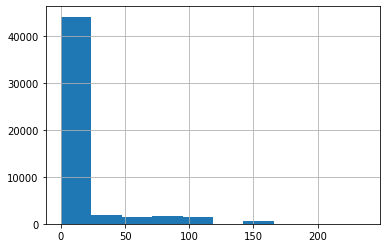

In [123]:
df_3.isna().sum(axis=1).hist()

In [124]:
df_3.isna().sum(axis=1).sort_values(ascending=False)

38941    237
8886     237
3558     236
36553    217
35014    217
        ... 
21805      0
21806      0
21807      0
21808      0
51123      0
Length: 51124, dtype: int64

In [126]:
ex = df_3.isna().sum(axis=1).to_frame()
ex = ex.rename({0:'values'}, axis=1)  # new method
ex

,values
0,1
1,0
2,0
3,0
4,0
...,...
51119,0
51120,0
51121,0
51122,32


In [138]:
helper_1 = ex.groupby('values').size().to_frame()
helper_1 = helper_1.rename({0:'values_f'}, axis=1)  # new method

In [139]:
helper_1.columns

Index(['values_f'], dtype='object')

In [145]:
helper_1['suma_acumulativa'] = helper_1['values_f'].cumsum()
helper_1

,values_f,suma acumulativa,suma_acumulativa
values,,,
0,31262,31262,31262
1,12365,43627,43627
2,481,44108,44108
20,1,44109,44109
21,1,44110,44110
25,2,44112,44112
26,1,44113,44113
27,4,44117,44117
28,94,44211,44211


In [149]:
helper_1['precentil_acumulativo'] = round(100*helper_1['suma_acumulativa']/helper_1['values_f'].sum(),3)
helper_1

,values_f,suma acumulativa,suma_acumulativa,precentil_acumulativo
values,,,,
0,31262,31262,31262,61.149
1,12365,43627,43627,85.336
2,481,44108,44108,86.277
20,1,44109,44109,86.278
21,1,44110,44110,86.280
25,2,44112,44112,86.284
26,1,44113,44113,86.286
27,4,44117,44117,86.294
28,94,44211,44211,86.478
